# Audio2Blendshape test notebook

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scripts.Dataset import a2bsDataset
from scripts.GrantNet import SimpleBSGen, FaceGenerator, RMSLELoss

## Initialize train-eval-test split
Set *build_cache=True* to buid cache if it doesn't already exist.

In [2]:
train_data = a2bsDataset(loader_type='train', mount_dir = '.', data_dir = 'datasets', build_cache=True, map_gb=2, is_win=False, file_cut=15, speaker_id=False)
train_loader = torch.utils.data.DataLoader(
            train_data, 
            batch_size=16,  
            shuffle=True,  
            num_workers=0,
            drop_last=True,
        )

Skipping ./datasets/1_wayne_0_111_118.
Skipping ./datasets/1_wayne_0_9_16.
Skipping ./datasets/1_wayne_0_41_48.


In [3]:
len(train_data)

4277

In [4]:
eval_data = a2bsDataset(loader_type='eval', mount_dir = '.', data_dir = 'datasets', build_cache=False,map_gb=1, is_win=False, speaker_id=False)
eval_loader = torch.utils.data.DataLoader(
            eval_data, 
            batch_size=16,  
            shuffle=True,  
            num_workers=0,
            drop_last=True,
        )

In [5]:
len(eval_data)

660

In [6]:
in_audio, facial, in_id = next(iter(train_loader))

In [7]:
print(in_audio.shape, facial.shape, in_id.shape)

torch.Size([16, 36266]) torch.Size([16, 34, 51]) torch.Size([16, 1])


In [8]:
net = SimpleBSGen()
optimizer = torch.optim.Adam( net.parameters(), lr=1e-3, weight_decay=1e-5)
loss_function = RMSLELoss()
train_loss = []
eval_loss = []

In [13]:
num_epochs = 3
log_period = 25
eval_period = 100

for epoch in range(num_epochs):
    for it, (in_audio, facial, in_id) in enumerate(train_loader):
        net.train()
        in_audio = in_audio
        facial = facial
        pre_frames = 4
        in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1))
        in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
        in_pre_face[:, 0:pre_frames, -1] = 1 
        
        optimizer.zero_grad()
        out_face = net(in_pre_face,in_audio)
        loss = loss_function(facial, out_face)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
        
        #logging
        if it % log_period == 0:
            print(f'[{epoch}][{it}/{len(train_loader)}] loss: {loss.item()}')
        
        if it % eval_period == 0:
            net.eval()
            eval_loss_st = []
            for _, (in_audio, facial, in_id) in enumerate(eval_loader):
                in_audio = in_audio
                facial = facial
                pre_frames = 4
                in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1))
                in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
                in_pre_face[:, 0:pre_frames, -1] = 1 

                out_face = net(in_pre_face,in_audio)
                loss = loss_function(facial, out_face)
                eval_loss_st.append(loss.item())
            
            eval_loss.append(np.average(eval_loss_st))
            print(f'[{epoch}][{it}/{len(train_loader)}] eval loss: {np.average(eval_loss_st)}')

[0][0/267] loss: 0.08659741282463074
[0][0/267] eval loss: 0.08501567455326639
[0][25/267] loss: 0.09492538869380951
[0][50/267] loss: 0.09056497365236282
[0][75/267] loss: 0.0903475359082222
[0][100/267] loss: 0.08265472203493118
[0][100/267] eval loss: 0.08262705512163115
[0][125/267] loss: 0.08022276312112808
[0][150/267] loss: 0.07850595563650131
[0][175/267] loss: 0.08346373587846756
[0][200/267] loss: 0.08201456815004349
[0][200/267] eval loss: 0.07514943146124119
[0][225/267] loss: 0.08847162872552872
[0][250/267] loss: 0.08464635908603668
[1][0/267] loss: 0.08114269375801086
[1][0/267] eval loss: 0.07949143775352617
[1][25/267] loss: 0.08955039829015732
[1][50/267] loss: 0.08163867145776749
[1][75/267] loss: 0.07034145295619965
[1][100/267] loss: 0.08132383227348328
[1][100/267] eval loss: 0.07563310207390203
[1][125/267] loss: 0.07639153301715851
[1][150/267] loss: 0.07039858400821686
[1][175/267] loss: 0.07430592179298401
[1][200/267] loss: 0.07734169065952301
[1][200/267] ev

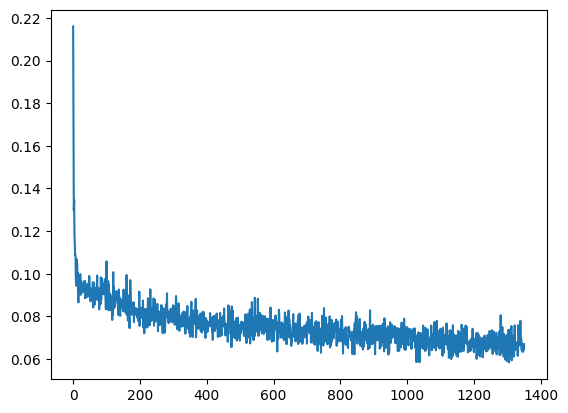

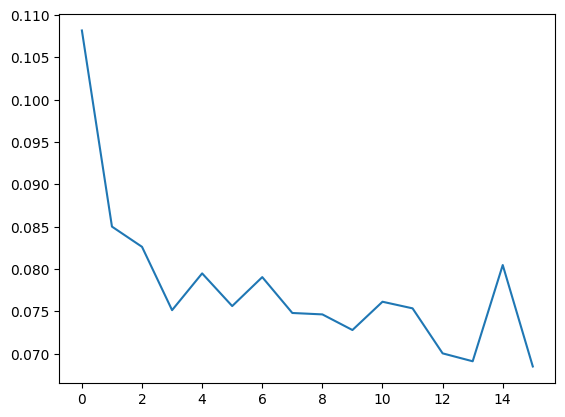

In [14]:
plt.plot(train_loss)
plt.show()
plt.plot(eval_loss)
plt.show()

In [24]:
net.load_state_dict(torch.load('ckpt_model/simplenet1.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
net.eval()
in_audio, facial, in_id = next(iter(eval_loader))
in_audio = in_audio
facial = facial
pre_frames = 4
in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1))
in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
in_pre_face[:, 0:pre_frames, -1] = 1 
out_face = net(in_pre_face, in_audio)

In [26]:
out_face.shape, facial.shape

(torch.Size([16, 34, 51]), torch.Size([16, 34, 51]))

In [27]:
out_face[0,:,7]

tensor([0.1781, 0.1712, 0.1755, 0.1824, 0.1780, 0.1749, 0.1759, 0.1780, 0.1705,
        0.1581, 0.1561, 0.1560, 0.1507, 0.1884, 0.2248, 0.2488, 0.2682, 0.2727,
        0.2677, 0.2565, 0.2345, 0.2055, 0.2164, 0.2204, 0.2087, 0.1896, 0.1800,
        0.1888, 0.1998, 0.1999, 0.1833, 0.1706, 0.1836, 0.2051],
       grad_fn=<SelectBackward0>)

In [28]:
facial[0,:,7]

tensor([0.1474, 0.1422, 0.1585, 0.1791, 0.1885, 0.1952, 0.1950, 0.1838, 0.1527,
        0.0911, 0.0729, 0.0720, 0.0733, 0.1466, 0.2323, 0.2953, 0.3288, 0.3548,
        0.3462, 0.3364, 0.2777, 0.2442, 0.2347, 0.2352, 0.2359, 0.2378, 0.2382,
        0.2310, 0.2135, 0.2099, 0.2095, 0.2305, 0.2592, 0.2307])

In [29]:
torch.save(net.state_dict(), 'ckpt_model/simplenet1.pth')

## Test set

In [30]:
import scipy
import math
import numpy as np
import torch
from tqdm import tqdm
from scripts.SimpleNet import FaceGenerator

In [31]:
test_audio_file = 'test_audio/out5.wav'
sr, test_audio_raw = scipy.io.wavfile.read(test_audio_file) # np array
test_audio = test_audio_raw[::sr//16000] # convert to 16khz
print('Original sample rate:', sr)

Original sample rate: 22050


In [32]:
len(test_audio)

225328

In [33]:
# need to separate into 32 frames, pass in 4 zeroed starting frames, set stride, do last frame fixes
facial_length = 34
facial_fps = 15
audio_fps = 16000
pre_frames = 4
stride = 4

In [34]:
net = SimpleBSGen().eval()

In [35]:
audio_start = 0
audio_end = audio_start + audio_short_length
face_start = 0
audio_short_length = math.floor(facial_length / facial_fps * audio_fps)
face_cache = np.zeros((1,(len(test_audio) * facial_fps) // audio_fps ,51))
with tqdm(total=(face_cache.shape[1]-facial_length)//stride+1) as pbar:
    while audio_end < len(test_audio):
        in_audio = torch.from_numpy(test_audio[audio_start:audio_end]).view(1,-1).float()
        pre_face = torch.from_numpy(face_cache[:,face_start:face_start+facial_length,:]).float()
        in_pre_face = pre_face.new_zeros((pre_face.shape[0], pre_face.shape[1], pre_face.shape[2] + 1))
        in_pre_face[:, face_start:face_start+pre_frames, :-1] = pre_face[:, face_start:face_start+pre_frames]
        in_pre_face[:, face_start:face_start+pre_frames, -1] = 1 
        #print(in_pre_face.shape, in_audio.shape)
        with torch.no_grad():
            out_face = net(in_pre_face, in_audio)

        face_cache[:,face_start:face_start+facial_length,:] = out_face.cpu().numpy()
    
        face_start += stride
        audio_start = (face_start*audio_fps)//facial_fps
        audio_end = audio_start + audio_short_length
        pbar.update(1)

NameError: name 'audio_short_length' is not defined

In [23]:
print(face_cache[:,-2,:])

NameError: name 'face_cache' is not defined